# Airplane Landing Scheduling with Metaheuristics

This notebook walks through:
1. Data loading
2. Feasible Baseline Heuristic
3. Simulated Annealing (SA)
4. Genetic Algorithm (GA)
5. Variable Neighborhood Search (VNS)
6. Results comparison


In [2]:
import sys, os
# Insert the *src* directory itself
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

# Now import direct modules
from landing_scheduler import compute_penalty, check_separation
from metaheuristics    import SimulatedAnnealing, GeneticAlgorithm, VariableNeighborhoodSearch
from utils             import load_data, plot_schedule


# Load data
data = load_data('data/landings.csv')
df = pd.read_csv('data/landings.csv')
df.head()

,aircraft_id,earliest,target,latest,earliness_penalty,lateness_penalty
0,AC1,16,44,66,2.54,4.02
1,AC2,26,59,80,1.06,2.70
2,AC3,26,48,68,1.92,1.83
3,AC4,9,41,66,1.96,3.27
4,AC5,27,52,77,3.73,1.13


## 2. Feasible Baseline Heuristic
Sort by target, apply separation shift, and verify feasibility.

Baseline penalty: 137.75
✔️ Separation constraint satisfied


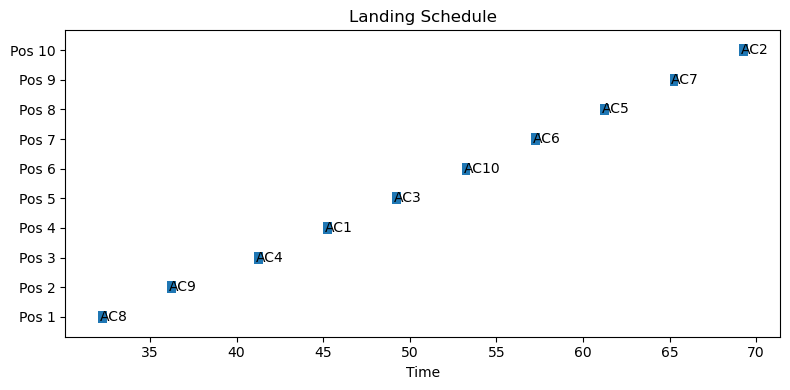

In [3]:
# 2. Feasible Baseline Heuristic (sort, shift, map)
n   = len(data['target'])
sep = 4.0

# a) Sequence by increasing target time
baseline_order = sorted(range(n), key=lambda i: data['target'][i])

# b) Compute position-based times with shifting
pos_times = np.zeros(n)
for pos, ac in enumerate(baseline_order):
    t_pref = data['target'][ac]
    t_ear  = data['earliest'][ac]
    if pos == 0:
        pos_times[pos] = max(t_ear, t_pref)
    else:
        prev = pos_times[pos-1]
        pos_times[pos] = max(t_ear, t_pref, prev + sep)

# c) Map to ID-indexed times array
times_by_id = np.zeros(n)
for pos, ac in enumerate(baseline_order):
    times_by_id[ac] = pos_times[pos]

# d) Compute penalty and check separation
baseline_pen = compute_penalty(times_by_id, **data)
print(f"Baseline penalty: {baseline_pen:.2f}")
assert check_separation(baseline_order, times_by_id, separation=sep)
print("✔️ Separation constraint satisfied")

# e) Plot schedule
plot_schedule(baseline_order, pos_times)

## 3. Simulated Annealing (SA)

SA best penalty: 0.00


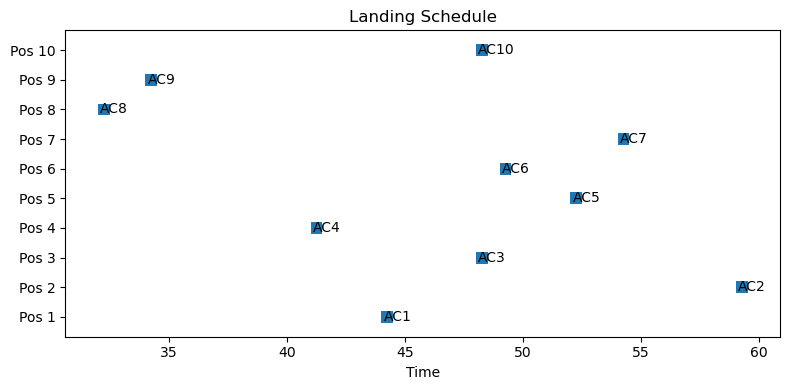

In [4]:
sa = SimulatedAnnealing(data, T0=1000, alpha=0.98, iter_per_temp=200)
best_order_sa, best_pen_sa = sa.run()
print(f"SA best penalty: {best_pen_sa:.2f}")
plot_schedule(best_order_sa, [data['target'][i] for i in best_order_sa])

## 4. Genetic Algorithm (GA)

In [7]:
ga = GeneticAlgorithm(data, pop_size=60, cx_rate=0.8, mut_rate=0.2, generations=100)
best_order_ga, best_pen_ga = ga.run()
print(f"GA best penalty: {best_pen_ga:.2f}")

if best_order_ga is None or not hasattr(best_order_ga, '__iter__') or np.isinf(best_pen_ga):
    print("⚠️ GA did not find a feasible solution. Try increasing population size or generations.")
else:
    plot_schedule(best_order_ga, [data['target'][i] for i in best_order_ga])


GA best penalty: inf
⚠️ GA did not find a feasible solution. Try increasing population size or generations.


## 5. Variable Neighborhood Search (VNS)

VNS best penalty: 0.00


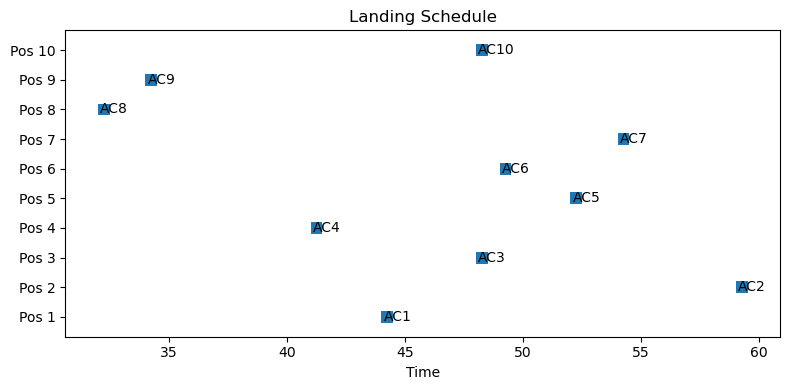

In [8]:
vns = VariableNeighborhoodSearch(data, max_iter=1000)
best_order_vns, best_pen_vns = vns.run()
print(f"VNS best penalty: {best_pen_vns:.2f}")
plot_schedule(best_order_vns, [data['target'][i] for i in best_order_vns])

## 6. Compare Methods

In [9]:
results = pd.DataFrame([
    {'Method':'Baseline','Penalty':baseline_pen},
    {'Method':'Simulated Annealing','Penalty':best_pen_sa},
    {'Method':'Genetic Algorithm','Penalty':best_pen_ga},
    {'Method':'Variable Neighborhood Search','Penalty':best_pen_vns},
])
results

,Method,Penalty
0,Baseline,137.75
1,Simulated Annealing,0.00
2,Genetic Algorithm,inf
3,Variable Neighborhood Search,0.00
